In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

import re
import string
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import sys
import os

from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.similarities import MatrixSimilarity
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from nltk import word_tokenize, WordNetLemmatizer, pos_tag
from nltk.corpus import stopwords, wordnet

from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint

% matplotlib inline

X:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# FILE PROCESSING 
def get_subtitle_fns(folder_fn_regex='srt/*'):
    return glob.glob(folder_fn_regex)

def get_subtitle_names(folder_fn_regex='srt/*'):
    filenames = glob.glob(folder_fn_regex)
    return [fn[4:-4] for fn in filenames] # remove srt\\ and .srt

In [27]:
# SUBTITLE PREPROCESSING
def get_subtitle_corpus(subtitle_fns):
    return [preprocess_movie_by_subs(s_fn) for s_fn in subtitle_fns]

def preprocess_movie_by_subs(subtitle_fn):
    print(subtitle_fn)
    return preprocess_subs(get_raw_subs(subtitle_fn))

def get_raw_subs(filename):
    # expected subtitle format:
        # numeric timestamp index
        # timestamp
        # subtitles on >= one line
        # linebreak

    # end of a subtitle line is expected to be a full word (i.e., not hyphenated)

    # subtitles may have the following qualities:
        # 1. markup (bold, italics, font colour) is between <> 
            # e.g., <font color="#00ff00"></font> 
        # 2. begin with hyphens
        # 3. contain punctuation
        # 4. begin (subtitle index 0) and end with subtitle credits of the same format 
        # 5. end with "The End"
        # 6. contain credits at the start of the subtitles 
    subs = []
    sub_chunk = []
    
    with open(filename, 'r') as f:
        for i, line in enumerate(f):          
            # collect subtitles for each timestamped subtitle chunk
            if line != '\n': # separate chunks are newline separated
                sub_chunk.append(line[:-1]) # remove newline
                continue
            
            # skip author credits
#             print(i, end=' ') # uncomment to find broken lines in .srt file
            sub_idx = sub_chunk[0]
            is_sub_author_credits = (sub_idx == '0')
            if is_sub_author_credits: 
                sub_chunk = []
                continue
            
            subs = add_sub(subs, sub_chunk)
                
            # reset for each timestamped chunk
            sub_chunk = [] 
    
    is_last_line_a_sub = (sub_chunk != []) # .srt sometimes ends with a newline
    if is_last_line_a_sub:
        sub = add_sub(subs, sub_chunk)
    
    return subs

def add_sub(subs, sub_chunk):
    for i, sub in enumerate(sub_chunk):            
        if i > 1: # index 0 and 1 are sub index and timestamp
            subs.append(sub)
    return subs

def preprocess_subs(raw):
    # remove markup
    markup = '<[^>]*>'
    subs = [re.sub(markup, '', r) for r in raw]
    
    # tokenisation case-folding
    subs = [word_tokenize(s.lower()) for s in subs]
    
    # remove stopwords and punctuation
    stops = set(stopwords.words('english'))
    stops = stops.union(string.punctuation)
    # in the paper, low information words were removed
    low_info_stops = ['uhh', 'ok', 'umm', 'ya', 'no', 'as', 'okay', "d'you", "goin'", 'alright', 'whoa', 'uh', 'ai', "'em", 'yo',
                     'eh', 'ah', 'ahh', 'hello', 'wan', 'aw', 'mr.', 'ow', 'yet', 'may', 'outta', 'hmm', "saw", 'ta', 'mm-hmm', 
                      '10', '5', 'use', '...', 'na', 'gon', 'ask', 'q', 'l', 'p', '1', '--', 
                      "''", '``', 'hey', 'maybe', 'san', 'lisa', 'michael', 'forrest', 'everybody', 'henry', 'tommy', 'sigh', 'john', 
                      'tracy', 'tom', 'harvey', 'jesse', '2', 'dan', 'nina', 'guy', 'reaiiy', 
                      'subtitle', 'andy', 'maybe', 'yeah', 'mr', 'put', 'everything', 'anybody', 'really', 'three', 'jimmy', 'frank', 'cole', 'james', 'jim',
                     'luke', 'leia', 'c-3po', 'r2', 'r2-d2', 'obi-wan', 'vader']
    stops = stops.union(low_info_stops)
    subs = [[t for t in sub if t not in stops] for sub in subs]
    
    # lemmatize
    pos = get_pos_tags(subs) # different POS lemmatize differently
    subs = [t for sub in subs for t in sub] # flatten
    lmtzr = WordNetLemmatizer()
    subs = [lmtzr.lemmatize(s, pos[i]) for i, s in enumerate(subs)]
        
    return subs

def get_pos_tags(subs):
    pos = [pos_tag(sub) for sub in subs]
    pos = [get_wordnet_pos(tag) for sub in pos for t, tag in sub] # flatten
    return pos

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else: # noun is default POS in WordNetLemmatizer
        return wordnet.NOUN

def get_vocabulary(bag_of_words):
    return set(bag_of_words)

def run_lda(corpus, dictionary, num_topics, is_save=False):
    num_topics = num_topics # paper used 55 for their corpus
    chunksize = 2000 # online learning improves topic models (Hoffman, Blei, & Bach, 2010))
    passes = 100 # TODO adjust this
    iterations = 500 # TODO adjust this --- passes and iterations must be adjusted to convergence
    eval_every = None # apparently evaluating model perplexity takes too much time?

    # logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # to get convergence logs

    lda = LdaModel(corpus, 
                   id2word=dictionary,
                   chunksize=chunksize,
                   passes=passes,
                   iterations=iterations,
                   num_topics=num_topics,
                   random_state=0,
                   eval_every=eval_every)
    
    if is_save:
        lda.save(datapath(sys.path[1] + '\\lda')) # absolute path
    
    return lda

def load_lda(filename):
    return LdaModel.load(filename)

In [28]:
def plot_average_topic_coherences(min_topics, avg_topic_coherences, filename=None):    
    index = np.arange(min_topics, min_topics + len(avg_topic_coherences), 1)
    col_name = 'avg_topic_coherence'
    df = pd.DataFrame(avg_topic_coherences, index=index, columns=[col_name])

    plt.plot(df)

    plt.ylabel('Mean Topic Coherence (UMass)')
    plt.xlabel('Number of Topics')

    if filename != None:
        fig = plt.gcf()
        fig.savefig(filename + ".pdf")
        
    plt.show()
    max_df = df[df[col_name] == df[col_name].max()]
    print('max avg topic coherence:', max_df.values[0][0])
    print('optimal topics:', max_df.index.values[0])

In [29]:
# CORPUS -> BAG OF WORDS (BOW) CORPUS 
movies_corpus = get_subtitle_corpus(get_subtitle_fns()) 
dictionary = Dictionary(movies_corpus) # fit

# In the paper, low information words based on how frequently they appear in 
# the intra-document and inter-document levels were removed:
    # 1. sparsely occurring words for each document; and 
    # 2. words frequent over the WHOLE collection
# First step was done above when removing stops, based on uninformative words that appeared in the topics
# when LDA was ran with these words included.
# Second step: remove words appearing in <no_below or >no_above% movies
dictionary.filter_extremes(no_below=4, no_above=0.95)

movies_corpus = [dictionary.doc2bow(movie) for movie in movies_corpus] # vect

srt\12 Angry Men.srt
srt\48 Hrs.srt
srt\City of God.srt
srt\Fight Club.srt
srt\First Blood.srt
srt\Forrest Gump.srt
srt\Goodfellas.srt
srt\Hard Times.srt
srt\Howl's Moving Castle.srt
srt\Inception.srt
srt\Life is Beautiful.srt
srt\LOTR Fellowship of the Ring.srt
srt\LOTR The Return of the King.srt
srt\LOTR The Two Towers.srt
srt\One Flew Over the Cuckoo's Nest.srt
srt\Ponyo.srt
srt\Princess Mononoke.srt
srt\Pulp Fiction.srt
srt\Saving Private Ryan.srt
srt\Schindler's List.srt
srt\Se7en.srt
srt\Seven Samurai.srt
srt\Southern Comfort.srt
srt\Spirited Away.srt
srt\Star Wars IV A New Hope.srt
srt\Star Wars V The Empire Strikes Back.srt
srt\Street of Fire.srt
srt\The Dark Knight.srt
srt\The Godfather Part II.srt
srt\The Good, the Bad and the Ugly.srt
srt\The Intouchables.srt
srt\The Long Riders.srt
srt\The Matrix.srt
srt\The Pianist.srt
srt\The Shawshank Redemption.srt
srt\The Usual Suspects.srt
srt\The Warriors.srt
srt\Uncommon Valor.srt
srt\Wake in Fright.srt


10 -0.4843188344512498
11 -0.5575917303362353
12 -0.49384232894757113
13 -0.5528763097680586
14 -0.596458481236108
15 -0.49777931284852817
16 -0.5431394960184173
17 -0.5419405326645036
18 -0.5560508974443372
19 -0.5358127305943355
20 -0.5133193000612019
21 -0.5266046829824291
22 -0.5263608531499107
23 -0.5344753987120814
24 -0.5919396655253428
25 -0.516461242710553


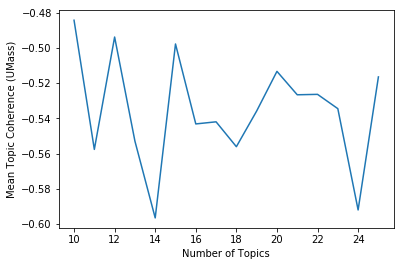

max avg topic coherence: -0.4843188344512498
optimal topics: 10
Wall time: 6min 23s


In [30]:
%%time
# USING BOW -> lDA, WHAT IS THE OPTIMAL NUMBER OF TOPICS? 

min_topic = 10
max_topic = 25

avg_topic_coherences = [0] * (max_topic - min_topic + 1)

for i in range(min_topic, max_topic+1):
    print(i, end=' ')
    lda = run_lda(movies_corpus, dictionary, i)
    top_topics = lda.top_topics(movies_corpus, topn=i)
    topic_coherence_idx = 1
    avg_topic_coherence = sum([t[topic_coherence_idx] for t in top_topics]) / i
    avg_topic_coherences[i-min_topic] = avg_topic_coherence
    print(avg_topic_coherence)
    
plot_average_topic_coherences(min_topic, avg_topic_coherences, filename='num_topics')

In [34]:
# Given the optimal number of topics, use LDA to compute topics
optimal_num_topics = 15
lda = run_lda(movies_corpus, dictionary, optimal_num_topics)
top_topics = lda.top_topics(movies_corpus, topn=30)
topic_coherence_idx = 1
avg_topic_coherence = sum([t[topic_coherence_idx] for t in top_topics]) / optimal_num_topics

print('Average topic coherence: %.4f' % avg_topic_coherence)
topic_coherences = [coherence for (topic_words, coherence) in top_topics]
topic_words = [topic_words for (topic_words, coherence) in top_topics]
topic_words = [[w for (wtl, w) in topic] for topic in topic_words]

for topic_coherence, words in zip(topic_coherences, topic_words):
    print(topic_coherence)
    print(words, '\n')

Average topic coherence: -0.4306
-0.2141196466070251
['fuck', 'money', 'kid', 'shit', 'real', 'big', 'kill', 'guy', 'cop', 'night', 'start', 'love', 'nothing', 'pay', 'hell', 'car', 'gun', 'care', 'as', 'god', 'head', 'drink', 'jack', 'lot', 'huh', 'great', 'ever', 'bad', 'girl', 'friend'] 

-0.2507728319529956
['bond', 'king', 'father', 'bomb', 'money', 'nothing', 'miss', 'bring', 'someone', 'afraid', 'men', 'safe', 'die', 'god', 'might', 'trust', 'course', 'innocent', 'choose', 'touch', 'head', 'job', 'world', 'thank', 'best', 'doctor', 'ready', 'meet', 'use', 'pay'] 

-0.2673613125430351
['shit', 'fuck', 'fuckin', 'kill', 'friend', 'money', 'family', 'believe', 'continue', 'big', 'goddamn', 'ever', 'car', 'brother', 'thank', 'as', 'nothing', 'new', 'deal', 'gun', 'business', 'old', 'remember', 'wife', 'baby', 'motherfucker', 'live', 'father', 'love', 'god'] 

-0.27153526590245003
['guilty', 'kid', 'kill', 'knife', 'vote', 'huh', 'old', 'second', 'point', 'heard', 'father', 'night', 

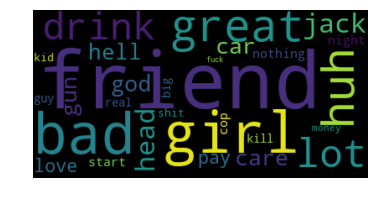

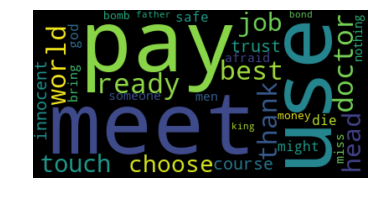

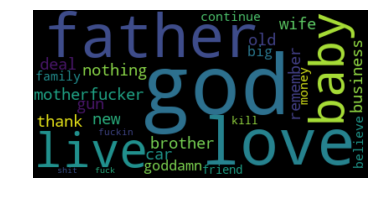

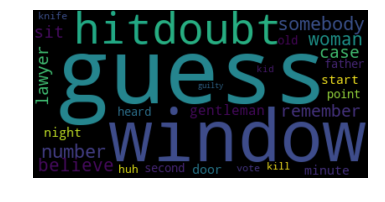

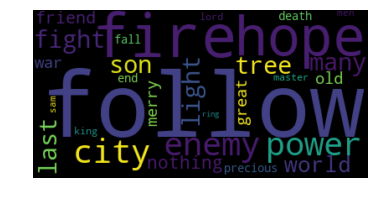

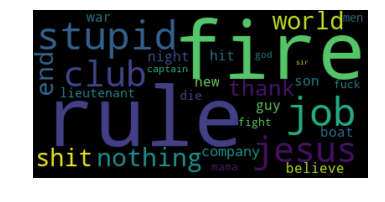

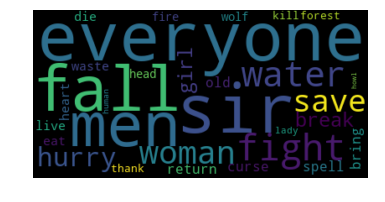

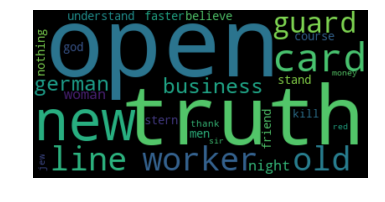

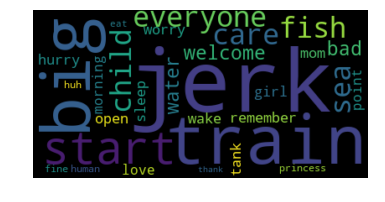

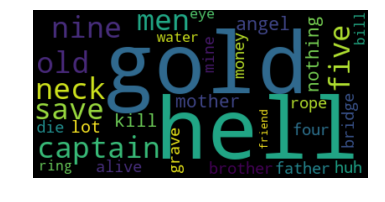

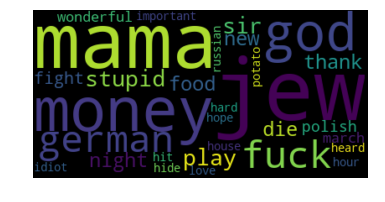

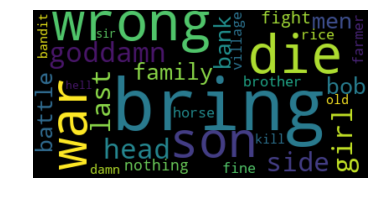

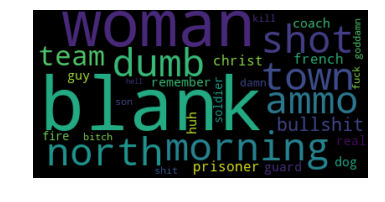

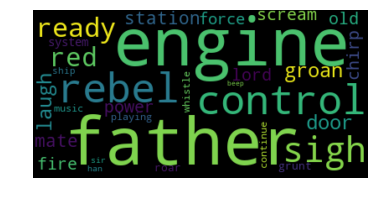

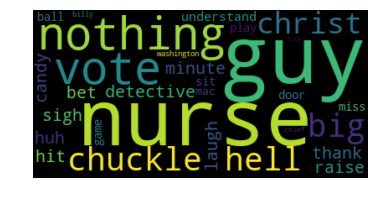

In [36]:
# VISUALISE WORD CLOUD FOR EACH TOPIC
def wordcloud(top_topics, optimal_num_topics=None):
    # based on inverse word likelihood for each topic
    word_topic_likelihood_idx = 0
    topic_coherence_idx = 1

    for i, top_topic in enumerate(top_topics):
        words = []

        for wtl, w in top_topic[word_topic_likelihood_idx]:
            frequency = int(round(1/wtl))
            words.append([w] * frequency)

        words = [w for word in words for w in word] # flatten
        words = " ".join(words) # WordCloud expects str

        wordcloud = WordCloud(max_words=30, collocations=False).generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        
        if optimal_num_topics != None:
            if not os.path.isdir(optimal_num_topics):
                os.mkdir(optimal_num_topics)
            fig = plt.gcf()
            fig.savefig(optimal_num_topics + "/wordcloud_" + str(i) + ".pdf")
            
        plt.show() 

wordcloud(top_topics, optimal_num_topics=str(optimal_num_topics))

In [37]:
# TOPIC SIMILARITY: cosine similarity between topic components 

def get_movie_similarity(index, subtitle_fn):    
    movie = preprocess_movie_by_subs(subtitle_fn)
    sims = index[lda[dictionary.doc2bow(movie)]]
    return sort_desc_movie_similarities(sims)

def get_movie_similarities(lda, index, movies_corpus):
    return [index[lda[movie]] for movie in movies_corpus]

def sort_desc_movie_similarities(sims):
    movie_names = get_subtitle_names()
    return sorted(zip(movie_names, sims), key=lambda sim: -sim[1])

index = MatrixSimilarity(lda[movies_corpus]) 
# if memory is an issue, use Similarity: https://radimrehurek.com/gensim/similarities/docsim.html
# "For example, a corpus of one million documents would require 2GB of RAM in a 256-dimensional LSI space, when used with this class."
# https://radimrehurek.com/gensim/tut3.html

movie_names = get_subtitle_names()
similarities = get_movie_similarities(lda, index, movies_corpus)

for movie, sims in zip(movie_names, similarities):
    print("*****", movie.upper(), "*****")
    print(sort_desc_movie_similarities(sims))
    print()

***** 12 ANGRY MEN *****
[('12 Angry Men', 1.0), ('The Usual Suspects', 0.16662218), ('Se7en', 0.04737808), ('The Shawshank Redemption', 0.029114207), ('48 Hrs', 0.0), ('City of God', 0.0), ('Fight Club', 0.0), ('First Blood', 0.0), ('Forrest Gump', 0.0), ('Goodfellas', 0.0), ('Hard Times', 0.0), ("Howl's Moving Castle", 0.0), ('Inception', 0.0), ('Life is Beautiful', 0.0), ('LOTR Fellowship of the Ring', 0.0), ('LOTR The Return of the King', 0.0), ('LOTR The Two Towers', 0.0), ("One Flew Over the Cuckoo's Nest", 0.0), ('Ponyo', 0.0), ('Princess Mononoke', 0.0), ('Pulp Fiction', 0.0), ('Saving Private Ryan', 0.0), ("Schindler's List", 0.0), ('Seven Samurai', 0.0), ('Southern Comfort', 0.0), ('Spirited Away', 0.0), ('Star Wars IV A New Hope', 0.0), ('Star Wars V The Empire Strikes Back', 0.0), ('Street of Fire', 0.0), ('The Dark Knight', 0.0), ('The Godfather Part II', 0.0), ('The Good, the Bad and the Ugly', 0.0), ('The Intouchables', 0.0), ('The Long Riders', 0.0), ('The Matrix', 0.0)

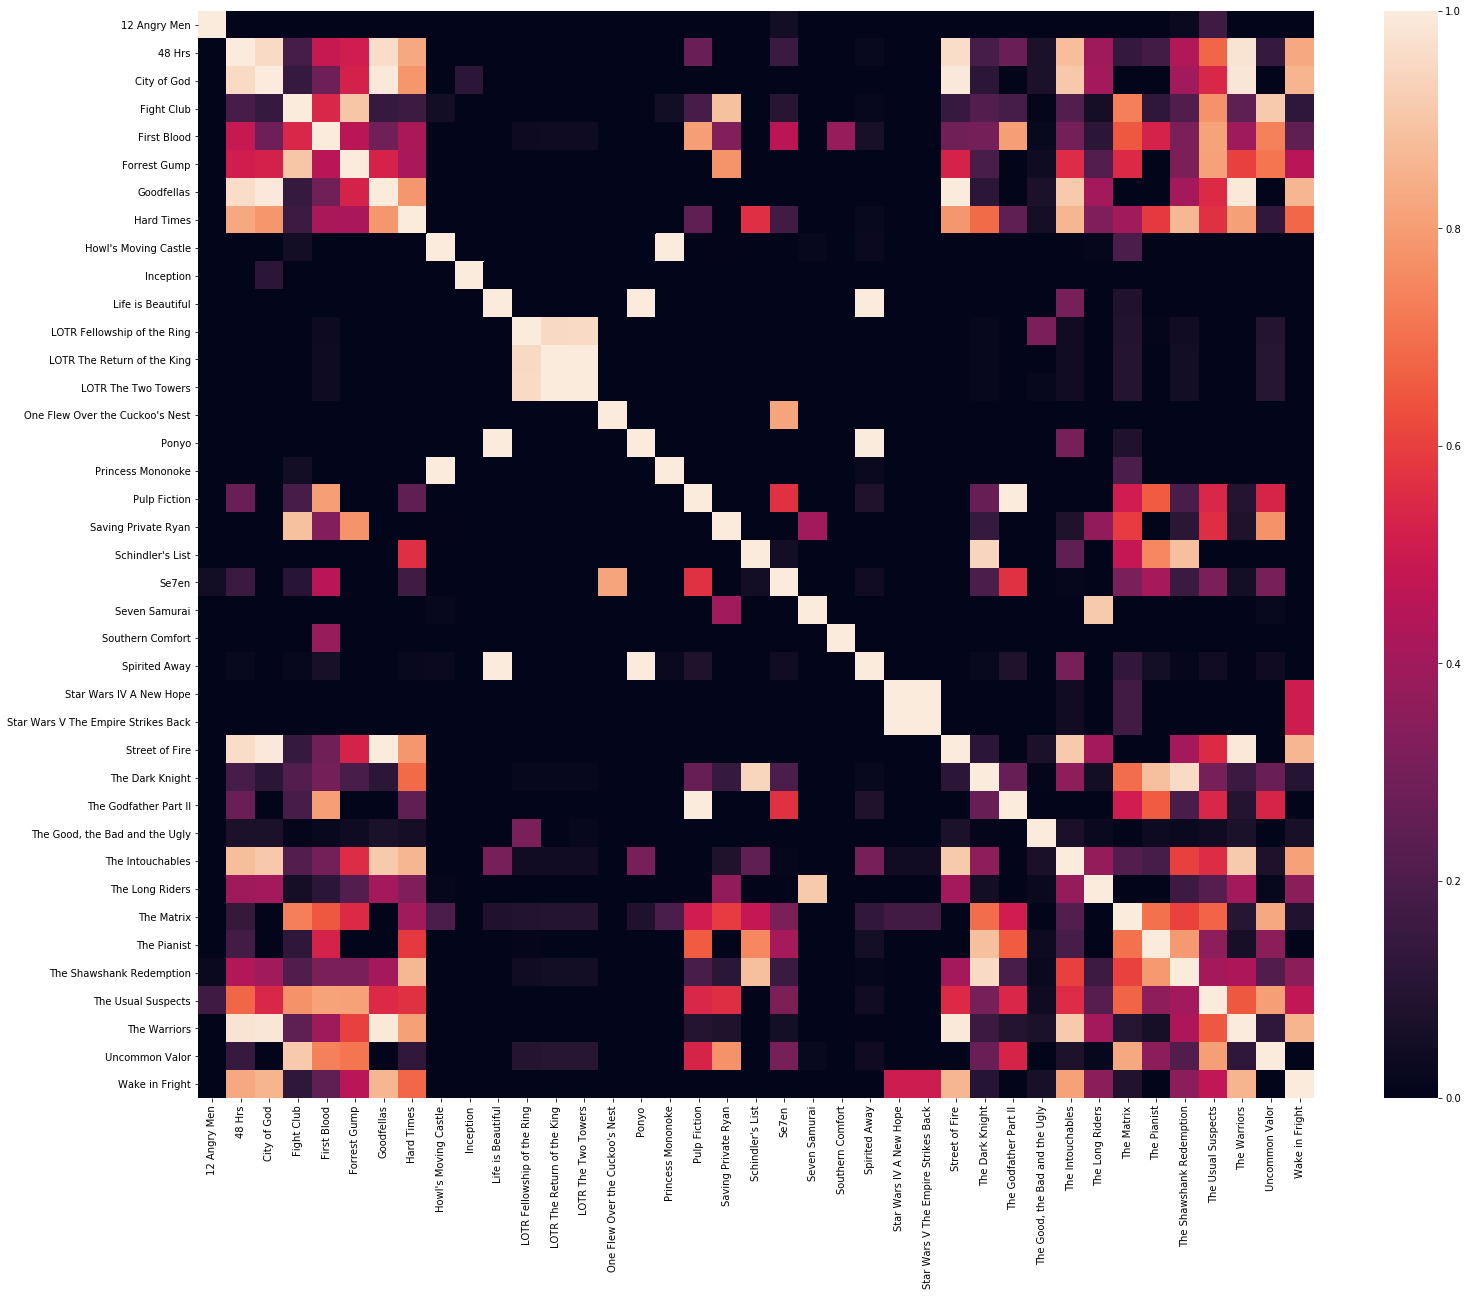

In [38]:
# VISUALISE TOTAL SIMILARITY MATRIX 
def heatmap(matrix, optimal_num_topics=None):
    plt.subplots(figsize=(25,20))
    movie_names = get_subtitle_names()
    hm = sns.heatmap(matrix, xticklabels=movie_names, yticklabels=movie_names)
    
    if optimal_num_topics != None:
        if not os.path.isdir(optimal_num_topics):
            os.mkdir(optimal_num_topics)
        hm.get_figure().savefig(optimal_num_topics + '/heatmap.pdf')

heatmap(get_movie_similarities(lda, index, movies_corpus), optimal_num_topics=str(optimal_num_topics))